# Amr Abdelhamed Abdala G5

##  Gradient decent for optmizing linear regrssion

#### Import numpy, matplotlib.pyplot and make it inline

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score ,mean_absolute_error , mean_squared_error
import seaborn as sns
%matplotlib inline
np.random.seed(611)

#### Read RegData csv file into numpy array  (check your data
##### Data source
https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html


In [2]:
data = np.genfromtxt("RegData.csv",delimiter =",")
x1d = data[:,0:1]
y1d = data[:,1:2]
print(x1d.shape)
print(y1d.shape)

(13, 1)
(13, 1)


#### Explore your data


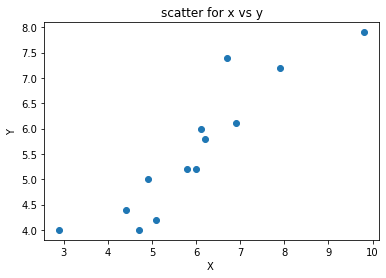

In [3]:
plt.scatter(x1d,y1d)
plt.xlabel("X ")
plt.ylabel("Y")
plt.title("scatter for x vs y")
plt.show()


* ### Feature vector X shape : (m,n) 
* ### Outcomes vector Y shape : (m,1) 
* ### $H(\theta)$ shape : (m,1) 
* ### So the shape of parameter vector $\theta$ : (1,n) 
* ### And shaoe of Gradients of each $\theta$ : (1,n)

## $$ h(\theta) = \theta_0 X_0 + \theta_1 X_1 + ... +\theta_n X_n $$

we can do same operation with matrix multiplication (dot product)

## $$ h(\theta) = X \theta_.T $$
#### check the shapes $$ (m,1) : (m,n) (n,1).T $$
---

## linear Regression Cost Function

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) $$

---

## Linear Regression Gradient

Correspondingly, the partial derivative of the cost function for regularized linear regression is defined as:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right)  & \qquad \text{for } j \ge 1
\end{align}
$$

use dot product implementation :

$$ \frac{\partial J(\theta)}{\partial \theta_n}  = \frac{1}{m} ( h_\theta  - Y)  X  $$
#### check the shape $$ (1,n) : ((m,1)-(m,1)).T   (m,n) $$
---

In [4]:
class GradientDecent():

    def __init__(self, x, y, maxiter,Batchsize= None, learining_rate=.001, stop_at=10**-10, monitor=True, norm=True ,
                 Gamma =0.9 ,Momentum =False ,Nestrov =False):
        """class constructor: initialize attributes and fit the model.
        Args:
            x (numpy array of numbers) : Feature matrix.
            y (numpy array of numbers) :  vector of outcome of each feature.
            learining_rate (float , optional = 0.001) :
            stop_at (float , optional = 10**-10) : iterate to reduce the gerdiants to be below stop_at.
            monitor (boolean , optional =True) : True , print the value of (the loss and the gradints) for each iteration. 
                                                 False , will print value of (the loss and the gradints) for last iteration.  

        """
        self.x = np.array(x)
        self.y = np.array(y)
        m = self.x.shape[0]
        n = self.x.shape[1]
        self.norm = norm
        self.xnorms = None
        self.ynorms = None
        self.stop_at = stop_at
        self.learining_rate = learining_rate
        self.theta = self.intilalizeTheta(n+1)
        self.historyLoss = pd.DataFrame(columns=["loss"])
        self.historyGradients = pd.DataFrame(
            columns=[f"G{i}" for i in range(n+1)])
        self.historyTheta = pd.DataFrame(
            columns=[f"Theta{i}" for i in range(n+1)])
        self.Gamma =Gamma
        self.Momentum =Momentum
        self.Nestrov = Nestrov
        if (Batchsize == m) or (Batchsize == None) :
            self.fitBatchGD(self.x, self.y, maxiter, monitor)
        elif (Batchsize < m) and (Batchsize > 1) :
            self.fitMiniBatchGD(self.x, self.y,Batchsize, maxiter, monitor)
        elif (Batchsize == 1):
            self.fitStochasticGD(self.x, self.y, maxiter, monitor)
        else: 
            print(f"Batch size must be in rage 1 to {m}")

    def intilalizeTheta(self, n):
        """Randomly intilalize Theta.

        Args:
            n (Intger): The lenght of theta vector

        Returns:
             (numpy array): vector with value of Theta
        """
        # return np.random.randint(1,9,size =(1,n))/10

        return np.zeros((1, n))

    def normalizex(self, x):
        """Normalize the feature vector and store the values of mean and standard deviation for normaliztion at perdiction.

        Args:
            x (numpy array) : the feature vector

        Returns:
            xnorm (numpy array) : Normlized version of feature vector
        """
        #if self.norm:
            #if self.xnorms == None:
           #     self.xnorms = {"mean": np.mean(x, 0), "std": np.std(x, 0)}
          #  xnorm = (x-self.xnorms['mean']) / self.xnorms['std']
         #   return xnorm
        #else:
        return x

    def normalizey(self, y):
        """Normalize the outcomes vector and store the values of mean and standard deviation
                    for denormaliztion to the perdictions.
        Args:
            y (numpy array) : the outcomes vector

        Returns:
            ynorm (numpy array) : Normlized version of outcomes vector
        """
       # if self.norm:
        #    if self.ynorms == None:
         #       self.ynorms = {"mean": np.mean(y, 0), "std": np.std(y, 0)}

          #  ynorm = (y-self.ynorms['mean']) / self.ynorms['std']
           # return ynorm
        #else:
        return y

    def addX1(self, x):
        """Add vector of ones to the feature vector to multiply with theta 0.

        Args:
            x (numpy array) : the feature vector

        Returns:
             (numpy array)
        """
        return np.append(np.ones((x.shape[0], 1)), x, axis=1)

    def lossmse(self, y, y_hat):
        """calculate error based on the Mean Square Error function.
        Args:
            y (numpy array): the outcomes vector
            y_hat (numpy array): the perdictions vector

        Returns:
            loss (float) 
        """
        m = y.shape[0]
        if m==0: m=1
        loss = np.sum((1/(2*m)) * (y_hat - y)**2)
        return loss

    def gradientsmse(self, y, y_hat, x):
        """calculate the gradints Mean Square Error function
        Args:
            y (numpy array): the outcomes vector
            y_hat (numpy array): the perdictions vector
            x (numpy array): the featurs vector
            theta (numpy array): the model parameters
        Returns:
            gradients (numpy array): value of gradients for each theta

        """
        m = y.shape[0]
        if m==0: m=1
        gradients = np.dot((y_hat - y).T, x)/m
        return gradients

    def toHistory(self, i, loss, gradients, theta):
        """cache the values of Loss ,Gradients and Theta for each ittration.
        Args:
            i (int): number of itteration
            loss (numpy.float) : error 
            gradients (numpy array): value of gradients for each theta
            theta (numpy array): the model parameters
        """
        self.historyLoss = self.historyLoss.append(
            pd.Series(loss, index=['loss']).T, ignore_index=True)
        self.historyGradients = self.historyGradients.append(pd.Series(gradients[0], index=self.historyGradients.columns),
                                                             ignore_index=True)
        self.historyTheta = self.historyTheta.append(pd.Series(theta[0], index=self.historyTheta.columns),
                                                     ignore_index=True)

    def monitor(self, idx, loss, gradients, theta):
        """print the values of Loss ,Gradients and Theta for each ittration.
        Args:
            idx (int) : number of itteration
            loss (int) : error 
            gradients (numpy array): value of gradients for each theta
            theta (numpy array): the model parameters
        """

        print(f"Iteration : {idx} , Loss = {loss} , Gradients = {gradients}")

    def fitBatchGD(self, x, y, maxiter, monitor=True):
        """fit linear regrestion model.

        Args:
            x (numpy array of numbers) : Feature matrix.
            y (numpy array of numbers) :  vector of outcome of each feature.
            monitor (boolean , optional =True) : True , print the value of (the loss and the gradints) for each iteration. 
                                                 False , will print value of (the loss and the gradints) for last iteration.
        """
        y = self.normalizey(y)
        x = self.addX1(self.normalizex(x))
        iteration = 1
        lossconter, thetaconter ,vt ,v_nestrov= 0 , 0 ,0 ,0
        while True:
            y_hat = np.dot(x, self.theta.T)
            loss = np.round(self.lossmse(y, y_hat), 10)
            if not self.Nestrov: v_nestrov = 0
            self.theta = self.theta - self.Gamma * v_nestrov
            grad = self.gradientsmse(y, y_hat, x) * self.learining_rate
            if not self.Momentum: vt =0
            vt = (self.Gamma* vt) + grad
            self.theta = self.theta - vt 
            v_nestrov = v_nestrov + grad
            
            self.toHistory(iteration, loss, grad, self.theta)
            sbreak,lossconter ,thetaconter = self._stop(iteration,lossconter ,thetaconter,maxiter,grad)
            
            if sbreak:
                self.monitor(iteration, loss, grad, self.theta)
                break

            if (monitor):
                self.monitor(iteration, loss, grad, self.theta)
            iteration += 1
            
    def fitMiniBatchGD(self, x, y, nBatchs,maxiter, monitor=True):
        """fit linear regrestion model.

        Args:
            x (numpy array of numbers) : Feature matrix.
            y (numpy array of numbers) :  vector of outcome of each feature.
            monitor (boolean , optional =True) : True , print the value of (the loss and the gradints) for each iteration. 
                                                 False , will print value of (the loss and the gradints) for last iteration.
        """
        y = self.normalizey(y)
        x = self.addX1(self.normalizex(x))
        iteration = 1
        lossconter, thetaconter ,batchCount= 0 , 0 ,1
        m = x.shape[0]
        batchstart ,batchend = 0, int(np.round(m/nBatchs,0))
        vt = 0.9
        while True:
            
            y_hat = np.dot(x[batchstart:batchend,:], self.theta.T)
            loss = np.round(self.lossmse(y[batchstart:batchend,:], y_hat), 10)
            grad = self.gradientsmse(y[batchstart:batchend,:], y_hat, x[batchstart:batchend,:])* self.learining_rate
            if not self.Momentum: vt =0
            vt = (self.Gamma* vt) + grad
            self.theta = self.theta - vt  
            self.toHistory(iteration, loss, grad, self.theta)
            
            sbreak,lossconter ,thetaconter = self._stop(iteration,lossconter ,thetaconter,maxiter,grad)
            if sbreak:
                self.monitor(iteration, loss, grad, self.theta)
                break
            if monitor:
                self.monitor(iteration, loss, grad, self.theta)
            
            if batchCount == nBatchs-1:
                batchstart ,batchend = int(batchCount *np.round(m/nBatchs,0)) , m
                batchCount =0
            else:
                batchstart ,batchend = int(batchCount *np.round(m/nBatchs,0)) , int(np.round(m/nBatchs,0) *(batchCount+1)) 
                batchCount +=1
            iteration += 1
        
    def fitStochasticGD(self, x, y,maxiter, monitor=True):
        """fit linear regrestion model.

        Args:
            x (numpy array of numbers) : Feature matrix.
            y (numpy array of numbers) :  vector of outcome of each feature.
            monitor (boolean , optional =True) : True , print the value of (the loss and the gradints) for each iteration. 
                                                 False , will print value of (the loss and the gradints) for last iteration.
        """
        print("stochastic")
        y = self.normalizey(y)
        x = self.addX1(self.normalizex(x))
        iteration = 1
        lossconter, thetaconter ,count= 0 , 0 ,0
        m = x.shape[0]
        vt = 0
        while True:
            y_hat = np.dot(x[count:count+1,:], self.theta.T)
            loss = np.round(self.lossmse(y[count:count+1,:], y_hat), 10)
            grad = self.gradientsmse(y[count:count+1,:], y_hat, x[count:count+1,:])* self.learining_rate
            if not self.Momentum: vt =0
            vt = (self.Gamma* vt) + grad
            self.theta = self.theta - vt 
            self.toHistory(iteration, loss, grad, self.theta)
            sbreak,lossconter ,thetaconter = self._stop(iteration,lossconter ,thetaconter,maxiter,grad)
            if sbreak:
                self.monitor(iteration, loss, grad, self.theta)
                break
            if monitor:
                self.monitor(iteration, loss, grad, self.theta)
            if count == (m-2): 
                count =0
            else: count += 1
                
            iteration += 1
            
        
    def _stop(self,iteration,lossconter ,thetaconter,maxiter,grad):
        sbreak = False
        if iteration > 4:
            if(np.all( np.abs(self.historyLoss.iloc[-2, :] - self.historyLoss.iloc[-1, :] )<= 10**-6)):
                lossconter += 1
            if(np.all(np.abs(self.historyTheta.iloc[-2, :] - self.historyTheta.iloc[-1, :]) <= 10**-8)):
                thetaconter += 1
            if (np.linalg.norm(grad) <= self.stop_at) or(iteration == maxiter) or (thetaconter == 30) or (lossconter == 30):
                sbreak = True
            #print(np.linalg.norm(grad) <= self.stop_at) , (iteration == maxiter) ,
            (thetaconter == 20), (lossconter == 20)
        return sbreak,lossconter ,thetaconter
                
    def pridict(self, xp):
        """make perdiction corresponding to provided values.
        Args:
            xp (numpy array of numbers) : Feature matrix to perdict values 

        Returns:
            prdictions: denormlized perdictions corresponding to xp values
        """
        xp = self.normalizex(xp)
        xp = self.addX1(xp)
        prdictions = np.dot(xp, self.theta.T)
        #if self.norm:
         #   prdictions = (prdictions*self.ynorms['std']) + self.ynorms['mean']
        return prdictions

    def plotModel(self, nx=0, xlabl="Feature", ylabl="outcomes", title="Fitted model", show=True):
        """plot the out comes and the model on one plot.
        Args:
            nx (int ,optional) : number of columen Feature to plot on x axies 
            xlabl (string ,optinal): X axies label for the plot
            ylabl (string ,optinal): Y axies label for the plot
            title (string ,optinal): plot Title 
        show (boolean ,optional) : true to show the plot 
                                        false to enable use of sub plots

        """
        plt.scatter(self.x[:, nx:nx+1], self.y, c="blue")
        plt.plot(self.x[:, nx:nx+1], self.pridict(self.x[:, nx:nx+1]), c="red")
        plt.xlabel(xlabl)
        plt.ylabel(ylabl)
        plt.title(title)
        if show:
            plt.show()

    def plotLoss(self, show=True):
        """plot the loss for each itteration.

        """
        plt.plot(self.historyLoss.index+1, self.historyLoss, c="red")
        plt.xlabel("Itterations")
        plt.ylabel("Loss")
        plt.title("loss For each itteration")
        if show:
            plt.show()

    def plotThetaVItteration(self, n_theta=0, show=True):
        """plot theta for itteration.
        Args:   
            n_theta (int): number of theta to plot for itteration
            show (boolean ,optional) : true to show the plot 
                                        false to enable use of sub plots
        """
        plt.plot(self.historyTheta.index, self.historyTheta[f"Theta{n_theta}"])
        plt.xlabel("Itterations")
        plt.ylabel(f"Theta{n_theta}")
        plt.title(f"Theta{n_theta} For each itteration")
        if show:
            plt.show()

    def plotThetaVloss(self, n_theta=0, show=True):
        """plot theta and the loss for itteration.
        Args:   
            n_theta (int ,optional ): number of theta to plot for itteration 
            show (boolean ,optional) : true to show the plot 
                                        false to enable use of sub plots 
        """
        plt.plot(self.historyTheta[f"Theta{n_theta}"], self.historyLoss)
        plt.xlabel(f"Theta{n_theta}")
        plt.ylabel("Loss")
        plt.title(f"Theta{n_theta} to loss for each itteration")
        if show:
            plt.show()

    def evalute(self, xe, ye):
        """evalute the model to corresponding data.
        Args:
            xe (numpy array) :Feature matrix to perdict values  
            ye (numpy array) : outcomes (True value ) 
        """
        yhat = self.pridict(xe)
        evalution = {"r2": r2_score(ye, yhat),
                     "Mean Absolute Error":  mean_absolute_error(ye, yhat),
                     "Mean Squared Error":  mean_squared_error(ye, yhat)}
        return evalution
    def plotall(self):
        nx =1
        
        x = self.addX1(self.x)
        thetavec= np.array(self.historyTheta)
        plt.scatter(self.x, self.y, c="blue")
        for i in range(thetavec.shape[0]-1):
            #print(x.shape,thetavec[i:i+1,:].shape)
            prdictions = np.dot(x, thetavec[i:i+1,:].T)
    
            plt.plot(self.x,prdictions , c="red")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("all lines")
        
        plt.show()


### Batch GD

In [5]:
G =GradientDecent(x1d,y1d,maxiter = 1000,learining_rate = .03,stop_at =10**-15,monitor=False,norm =False)

Iteration : 1000 , Loss = 0.1433737592 , Gradients = [[-3.35633730e-04  5.24578886e-05]]


In [6]:
G.theta

array([[1.27333968, 0.71965692]])

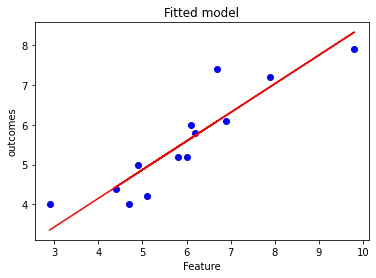

In [7]:
G.plotModel()

<Figure size 504x504 with 0 Axes>

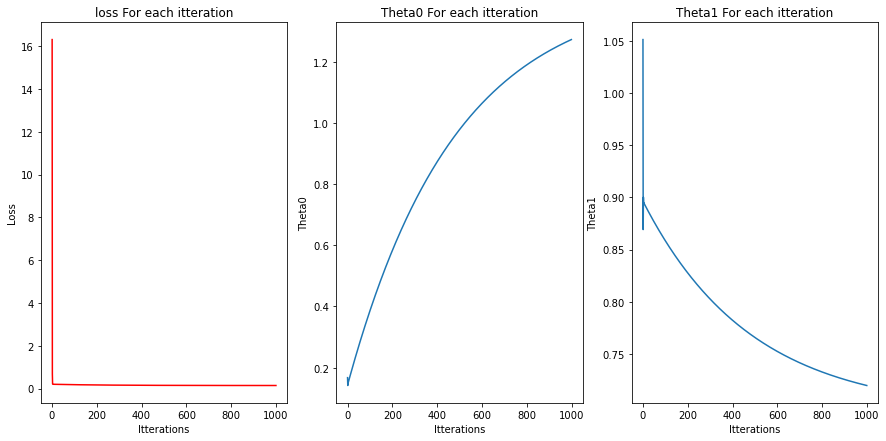

In [8]:
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=3,figsize = (15,7))
plt.subplot(1, 3, 1)
G.plotLoss(False)
plt.subplot(1, 3, 2)
G.plotThetaVItteration(0,False)
plt.subplot(1, 3, 3)
G.plotThetaVItteration(1,False)
plt.show()

<Figure size 504x504 with 0 Axes>

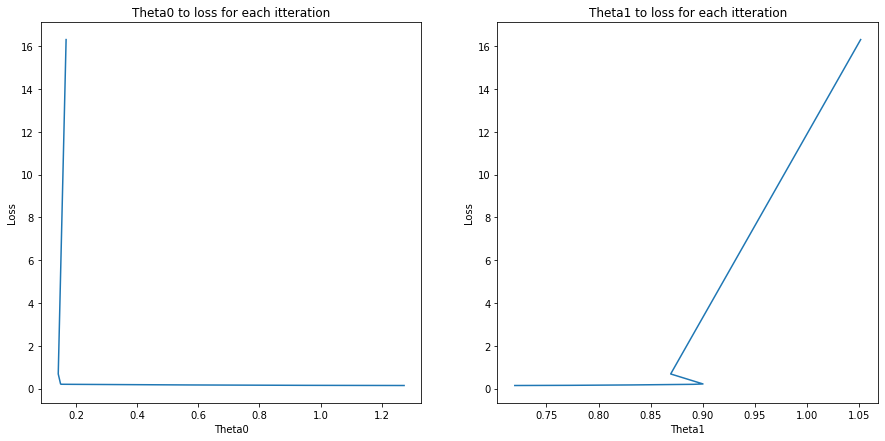

In [9]:
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=2,figsize = (15,7))
plt.subplot(1, 2, 1)
G.plotThetaVloss(0,False)
plt.subplot(1, 2, 2)
G.plotThetaVloss(1,False)
plt.show()



In [10]:
print(G.evalute(x1d,y1d))

{'r2': 0.8201624357731964, 'Mean Absolute Error': 0.4177381491708058, 'Mean Squared Error': 0.2867398330295179}


## Multivariate LR

#### Read MultipleLR csv file into numpy array  (check your data)
##### Data source
https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html


In [11]:
"""
data = np.genfromtxt("MultipleLR.csv",delimiter =",")
x = data[:,0:-1]
y = data[:,-2:-1]
print(x.shape)
print(y.shape)
"""

'\ndata = np.genfromtxt("MultipleLR.csv",delimiter =",")\nx = data[:,0:-1]\ny = data[:,-2:-1]\nprint(x.shape)\nprint(y.shape)\n'

In [12]:
#sns.pairplot(pd.DataFrame(data))
#plt.show()


In [13]:
x = np.linspace(0,20).reshape((-1,1))
a = -2 
b = 1
y = a*x + b 
x.shape
y.shape

(50, 1)

### fit model with  batch GD

In [65]:
G =GradientDecent(x,y,maxiter = 1000,learining_rate = .001,stop_at =10**-15,monitor=False)

Iteration : 1000 , Loss = 0.1007503817 , Gradients = [[-2.26567077e-04  1.68529400e-05]]


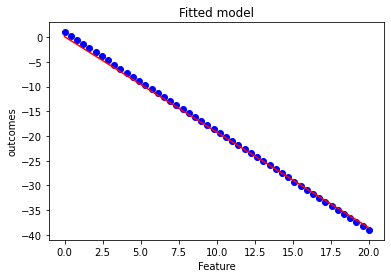

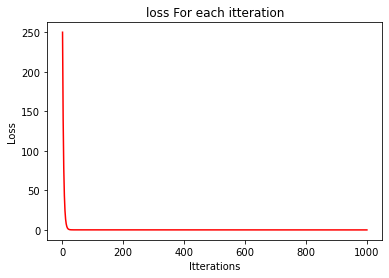

<Figure size 504x504 with 0 Axes>

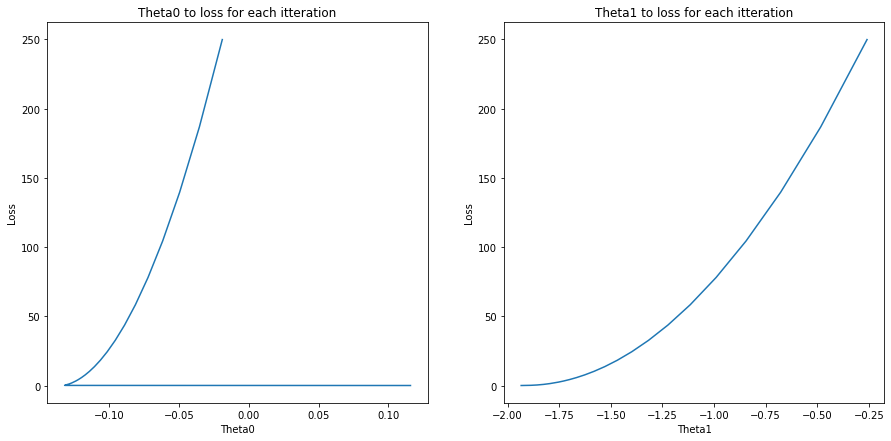

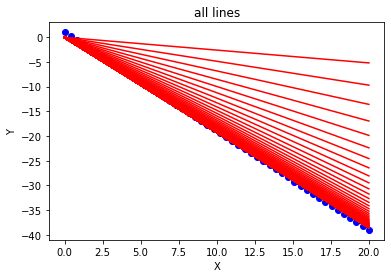

{'r2': 0.9985487529969077, 'Mean Absolute Error': 0.3736988423154318, 'Mean Squared Error': 0.20139754328627063}


In [66]:
G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))

### fit model with MINI batch GD

In [63]:
G =GradientDecent(x,y,maxiter = 1000,Batchsize= 20,learining_rate = .0001,stop_at =10**-8,monitor=False,Momentum =False)


Iteration : 1000 , Loss = 0.2469977444 , Gradients = [[6.87654229e-05 1.24141719e-03]]


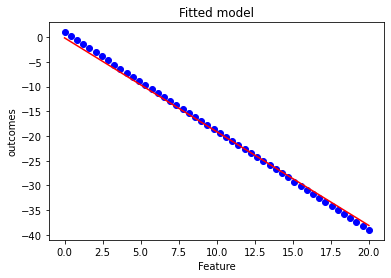

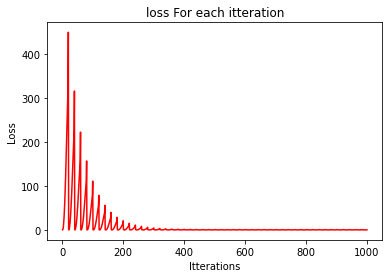

<Figure size 504x504 with 0 Axes>

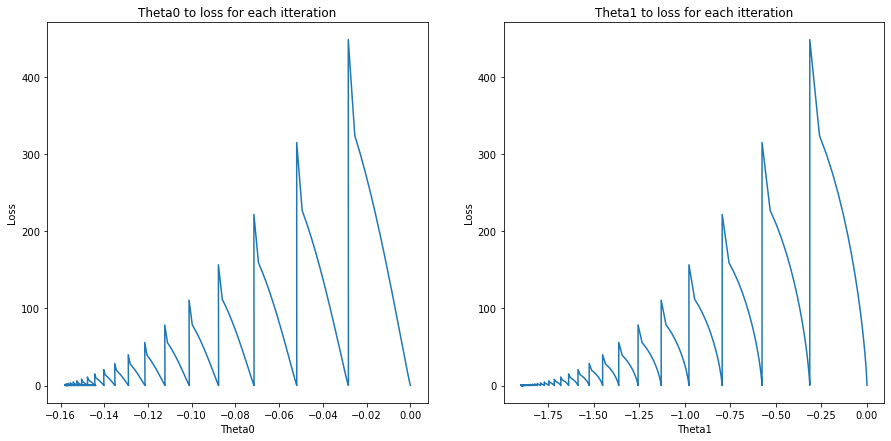

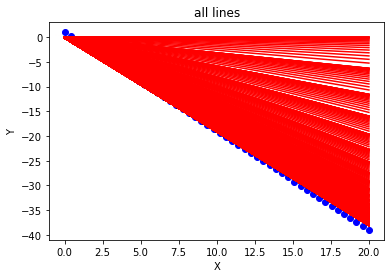

{'r2': 0.9972908714938502, 'Mean Absolute Error': 0.5274831753490248, 'Mean Squared Error': 0.3759606906493581}


In [64]:
G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))

### fit model with stochastic GD

stochastic
Iteration : 1000 , Loss = 0.1081243093 , Gradients = [[-4.65025396e-05 -3.60631940e-04]]


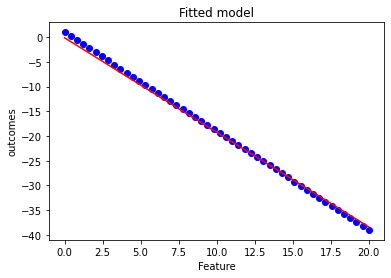

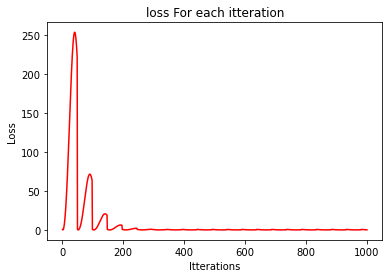

<Figure size 504x504 with 0 Axes>

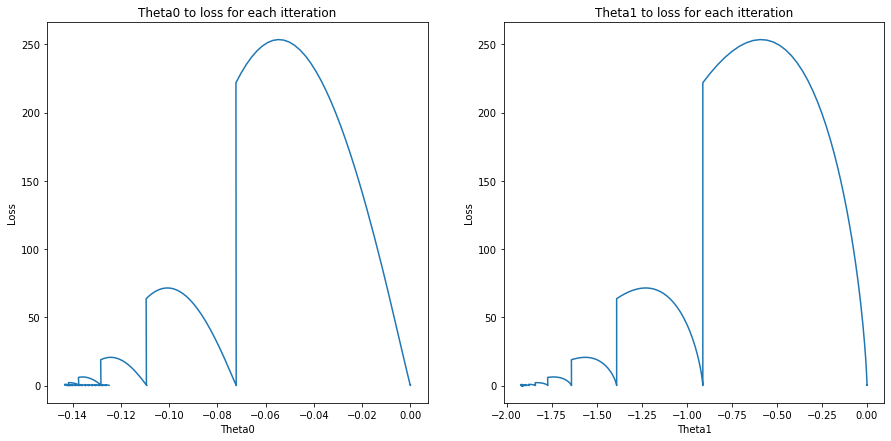

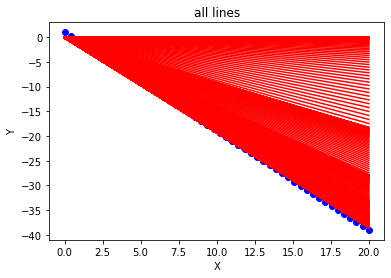

{'r2': 0.9976476327474494, 'Mean Absolute Error': 0.47786811358108605, 'Mean Squared Error': 0.32645096566008264}


In [69]:
G =GradientDecent(x,y,maxiter = 1000,Batchsize= 1,learining_rate = .0001,stop_at =10**-8,monitor=False,Momentum =False)

G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))

### fit model with Batch GD and Momentum

Iteration : 1000 , Loss = 0.0681159148 , Gradients = [[-2.79440280e-04  2.07858544e-05]]


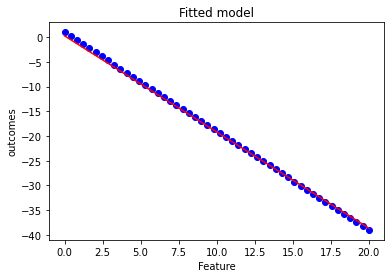

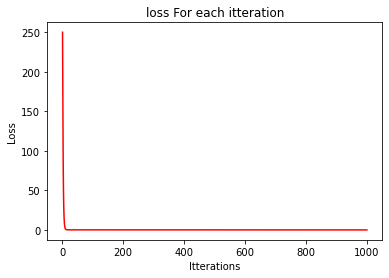

<Figure size 504x504 with 0 Axes>

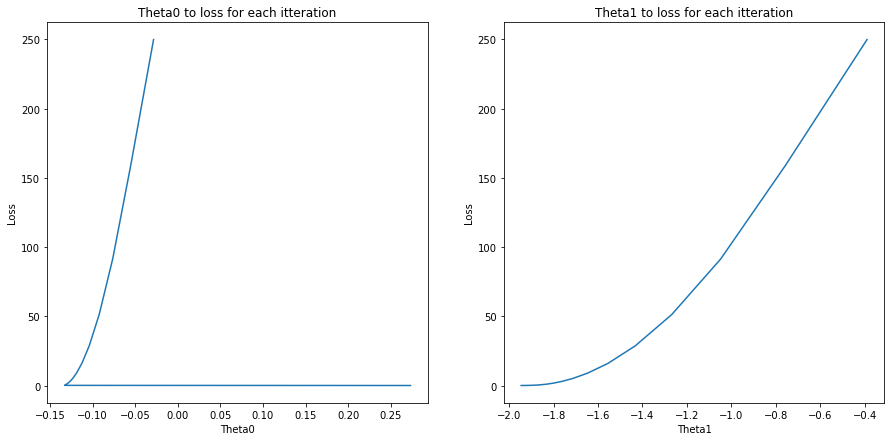

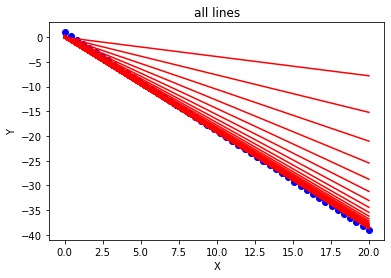

{'r2': 0.9990192168593621, 'Mean Absolute Error': 0.3072115789407421, 'Mean Squared Error': 0.13610868074158095}


In [53]:
G =GradientDecent(x,y,maxiter = 1000,learining_rate = .0015,stop_at =10**-8,monitor=False,Momentum =True,Gamma= .15)

G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))


### fit model with Mini Batch GD and Momentum

Iteration : 1000 , Loss = 0.0346869541 , Gradients = [[0.00051244 0.00945063]]


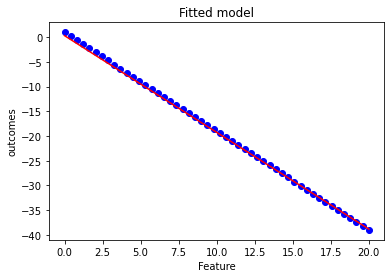

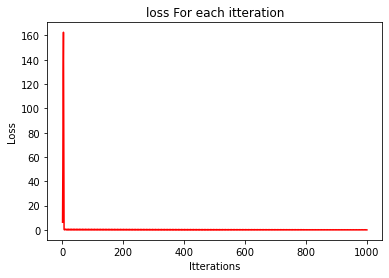

<Figure size 504x504 with 0 Axes>

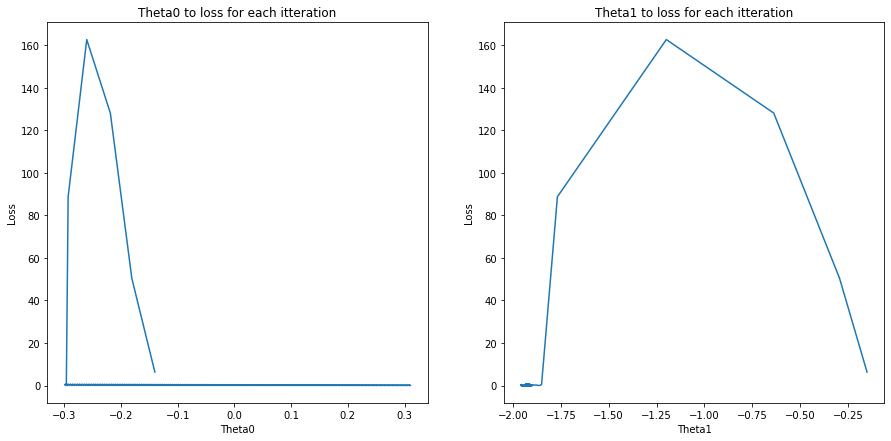

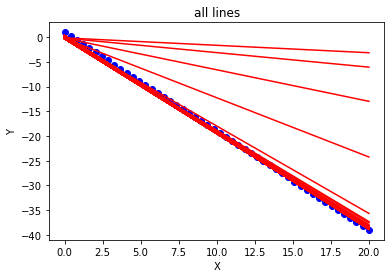

{'r2': 0.9990413934447275, 'Mean Absolute Error': 0.29793729553732895, 'Mean Squared Error': 0.13303111379290722}


In [51]:
G =GradientDecent(x,y,maxiter = 1000,Batchsize= 5,learining_rate = .002,stop_at =10**-30,monitor=False,Momentum =True,Gamma= .15)

G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))

### fit model with stochastic GD and Momentum

stochastic
Iteration : 1500 , Loss = 0.0055016466 , Gradients = [[0.00020979 0.00248327]]


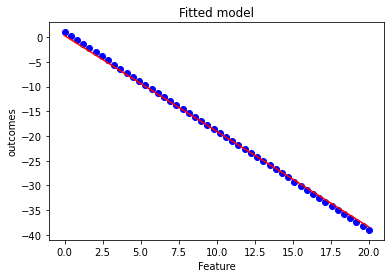

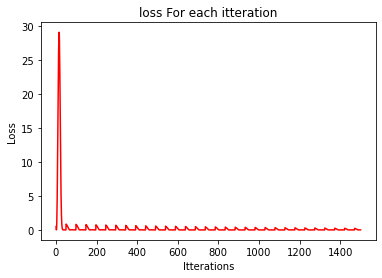

<Figure size 504x504 with 0 Axes>

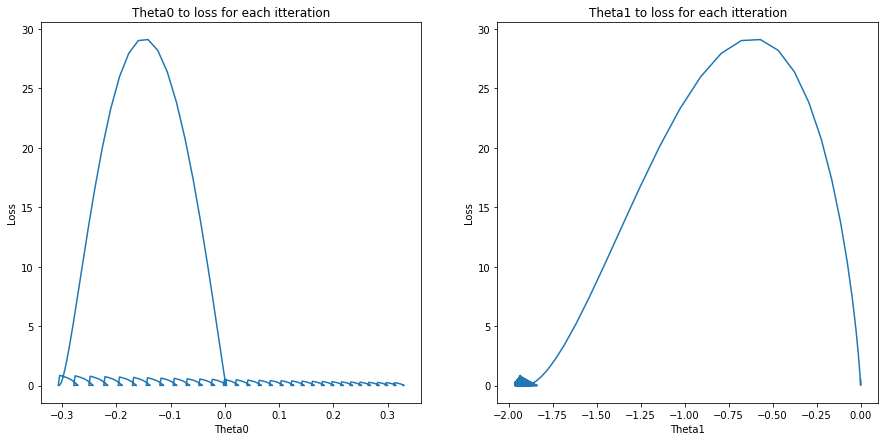

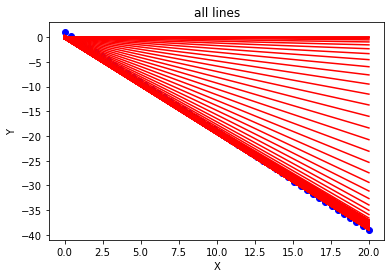

{'r2': 0.9990042655425961, 'Mean Absolute Error': 0.32117315720921186, 'Mean Squared Error': 0.13818355735400945}


In [50]:
G =GradientDecent(x,y,maxiter = 1500,Batchsize= 1,learining_rate = .002,stop_at =10**-5,monitor=False,Momentum =True
                  ,Gamma= .15)

G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))

### fit model with Batch GD and nestrov


Iteration : 1500 , Loss = 0.0595717053 , Gradients = [[-3.48436356e-04  2.59180508e-05]]


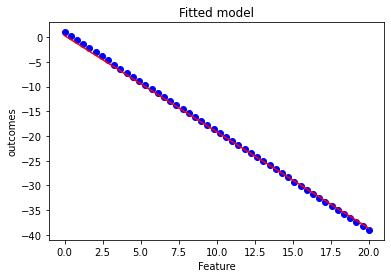

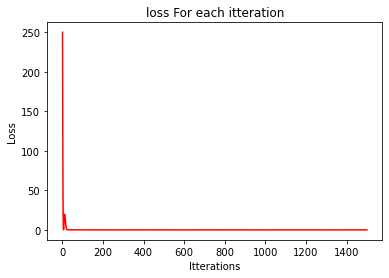

<Figure size 504x504 with 0 Axes>

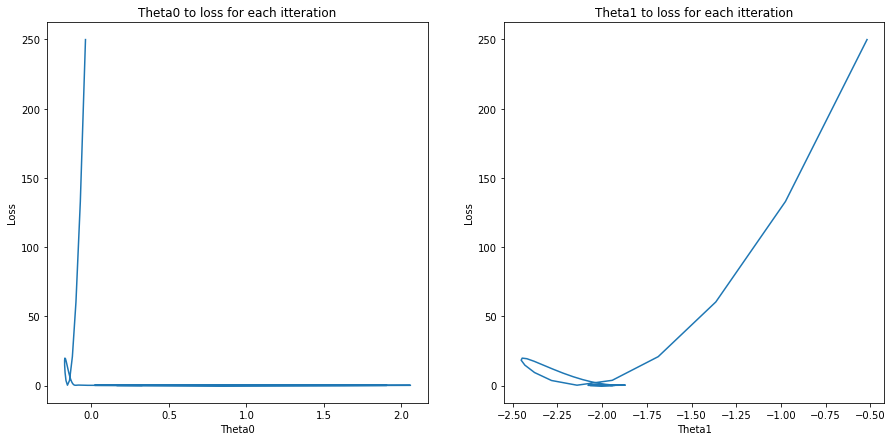

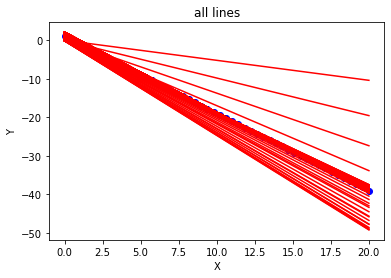

{'r2': 0.9991521879723958, 'Mean Absolute Error': 0.28562806071420943, 'Mean Squared Error': 0.11765554668793471}


In [47]:
G =GradientDecent(x,y,maxiter = 1500,Batchsize= None,learining_rate = .002,stop_at =10**-8,monitor=False,Momentum =False,
                  Gamma= .15,Nestrov = True)

G.plotModel()
G.plotLoss()
plt.figure(figsize = (7,7))
plt.subplots(nrows=1, ncols=G.theta.shape[1],figsize = (15,7))
for i in range(0,G.theta.shape[1]):
    plt.subplot(1, G.theta.shape[1], i+1)
    G.plotThetaVloss(i,False)
plt.show()
G.plotall()
print(G.evalute(x,y))